# Deep learning with ICCD images of plasma plumes generated during pulsed laser deposition for growth kinetics prediction - Mixed Model

#### Sumner B. Harris

This notebook is designed to provide a functional example of using a mixed input (2+1)D CNN + MLP to extract deep features from ICCD image sequences and growth parameters for growth kinetics prediction during pulsed laser deposition (PLD).

Start by importing the required packages:

In [1]:
# Import some basics
import os
import datetime

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Import our custom modules
import ICCDutils
import models

# Import Torch stuff
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

## Define the dataset class

In [2]:
class PLDdataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform, target_params, augment=True):
        self.df = dataframe
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get growth parameters
        params = torch.tensor([self.df.loc[idx,'P'],self.df.loc[idx,'T'],self.df.loc[idx,'E1'],self.df.loc[idx,'E2']],dtype=torch.float32)
        
        # get targets
        if target_params == 'anomaly':
            target = torch.tensor([self.df.loc[idx,'P'],self.df.loc[idx,'E1'],self.df.loc[idx,'E2']],dtype=torch.float32)
        if target_params == 'growth':
            target = torch.tensor([self.df.loc[idx,'s0'],self.df.loc[idx,'s1'],self.df.loc[idx,'J']],dtype=torch.float32)

        # get ICCD image sequence
        image1 = torch.tensor(self.df.loc[idx,'ICCD'],dtype=torch.float32)

        if self.augment:
            image1 = self.transform(image1)      
            # add measurement noise to parameters for augmentation
            params[0] = params[0] + torch.randn(1)*2*np.sqrt(params[0]*0.00125) # account for 2 sigma, 0.25% baratron accuracy
            params[1] = params[1] + torch.randn(1)*2*np.sqrt(params[1]*0.0075)# account for 2 sigma, 1.5% temperature
            params[2] = params[2] + torch.randn(1)*2*np.sqrt(params[2]*0.0075)# account for 2 sigma, 1.5% laser stability accuracy
            params[3] = params[3] + torch.randn(1)*2*np.sqrt(params[3]*0.0075)# account for 2 sigma, 1.5% laser stability accuracy

        return image1, params, target

## Make a helper function to load the data and split into training and validation sets

In [3]:
def load_data(datafile, target_params, normalize_PTE1E2, train_percent=70):
    # Create a transform for the ICCD images
    transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
    
    # load the full data from the json file
    df = ICCDutils.load_df(datafile, normalize_PTE1E2=normalize_PTE1E2)
    
    train_number = int(len(df)*train_percent/100)
    val_number = len(df)-train_number
    print('Total number of samples: {}'.format(len(df)))
    print('Number of training samples: {}\nNumber of validation samples: {}'.format(train_number, val_number))
    
    # instantiate the PLDdataset class
    dataset = PLDdataset(df, transform, target_params)
    
    # set a seed for reproducibility
    generator = torch.Generator().manual_seed(42)
    
    # randomly split the data into training and validation sets
    train_data, val_data = random_split(dataset,[train_number,val_number],generator=generator)
    
    return train_data, val_data

# Define the training function

In [10]:
def model_train_best(config, target_params, normalize_PTE1E2, chk_name):
    train_loss_list = []
    test_loss_list = []
    r2_list = []
    print(config['c1'],config['c2'],config['c3'])
    print("I'M TRAINING, I'M TRAINING!!")
    model = models.MixedICCDNet(l1=config['l1'],l2=config['l2'],param_l1=config['param_l1'],param_out=config['param_out'],c1=config['c1'],c2=config['c2'])
    
    if config['ICCD checkpoint'] != None:
        weights = torch.load(config["ICCD checkpoint"])
        model.load_state_dict(weights,strict=False)
        #Freeze all layers in the ICCD_features_ part
        for param in model.ICCD_features_.parameters():
            param.requires_grad = False
        print('Loaded ICCD layers...')
        for param in model.ICCD_features_.parameters():
            if param.requires_grad:
                print('ERROR:Found trainable in ICCD')
        
    if config['MLP checkpoint'] != None:
        weights = torch.load(config['MLP checkpoint'])
        model.load_state_dict(weights,strict=False)
        #Freeze all layers in the parameter_features part
        for param in model.parameter_features.parameters():
            param.requires_grad = False
        print('Loaded parameter MLP layers...')
        for param in model.parameter_features.parameters():
            if param.requires_grad:
                print('ERROR:Found trainable in ICCD')
    
    device = 'cpu'
    if torch.cuda.is_available():
        print('Using GPU.')
        device = "cuda:0"    
        if torch.cuda.device_count() > 1:
            print('Using multiple GPUs.')
            model = nn.DataParallel(model)
    model.to(device)
    loss_fn = nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=config['lr'],amsgrad=True,weight_decay=config['weight_decay'])
    
    BATCH_SIZE = 88
    train_data, val_data = load_data(datafile, target_params, normalize_PTE1E2, train_percent=70)
    
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

    #print('Total image feature params:',sum(p.numel() for p in model.ICCD_features_.parameters()))
    #print('Total model params:',sum(p.numel() for p in model.parameters()))

    loss_values = []
    val_loss_values = []
    best_R2 = 0.0
    n_epochs=2000
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        for id_batch, (image1,params,target) in enumerate(train_loader):
            image1=image1.to(device)
            params=params.to(device)
            score = target.to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(image1,params)
            loss = loss_fn(y_pred, score)

            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_values.append(loss_train/len(train_loader))
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch,
                                                          loss_train / len(train_loader)))
        
        train_pred, train_actuals = y_pred.cpu(), score.cpu()
        size = len(val_loader.dataset)
        num_batches = len(val_loader)
        test_loss = 0.0
        train_loss_list.append(loss_train)
        
        for (image1,params,target) in val_loader:
            with torch.no_grad():
                image1=image1.to(device)
                params=params.to(device)
                score = target.to(device)
                pred = model(image1,params)
                test_loss += loss_fn(pred, score).item()
                pr2 = pearsonr(score[:,0].cpu(), pred[:,0].cpu())[0]**2
                e1r2 = pearsonr(score[:,1].cpu(), pred[:,1].cpu())[0]**2
                e2r2 = pearsonr(score[:,2].cpu(), pred[:,2].cpu())[0]**2
                meanR2 = np.array([pr2,e1r2,e2r2]).mean()
                print('R2 values {:.4f}, {:.4f}, {:.4f}; mean R2={:.4f}'.format(pr2, e1r2, e2r2, meanR2))
                r2_list.append([pr2, e1r2, e2r2,meanR2])
                
        if meanR2>best_R2:
            print('New best, saving checkpoint...')
            best_R2 = meanR2
            best_val_predictions, best_val_actuals = pred.cpu().detach(), score.cpu().detach()
            best_train_predictions, best_train_actuals = train_pred.cpu().detach(), train_actuals.cpu().detach()
            
            torch.save(model.state_dict(), 'Model Checkpoints/MixedICCDNet_from_checkpoints.model')
        test_loss /= num_batches
        test_loss_list.append(test_loss)
        val_loss_values.append(test_loss)
        print(f"Test Error: Avg loss: {test_loss:>8f} \n")
        #train.report({"mean_R2": meanR2})
        
    return best_R2, train_loss_list, test_loss_list, r2_list, best_train_predictions, best_train_actuals, best_val_predictions, best_val_actuals

# Set up the configuration and train the model

In [13]:
ICCD_checkpoint= 'Model Checkpoints/ICCDNet_l1-64.0000_l2-32.0000_lr-0.0014_L2-0.0005.model'
MLP_checkpoint= 'Model Checkpoints/MLP_l1-48.0000_l2-32.0000_lr-0.0112_L2-0.0003.model'

config = {
        "l1": 64,
        "l2": 32,
        "param_l1": 48,
        "param_out": 32,
        "c1": 16,
        "c2": 24,
        "c3": 32,
        "lr": 0.001055047107715595,
        "weight_decay": 0.0018287918531623708,
        "ICCD checkpoint": os.path.abspath(ICCD_checkpoint),
        "MLP checkpoint": os.path.abspath(MLP_checkpoint)
}

datafile = 'PLD data.json'
target_params = 'growth'
normalize_PTE1E2 = True
chk_name = 'Mixed growth from checkpoints'

BATCH_SIZE = 88

best_R2, train_loss_list, test_loss_list, r2_list, best_train_predictions, best_train_actuals, best_val_predictions, best_val_actuals = model_train_best(config, target_params, normalize_PTE1E2, chk_name)

16 24 32
I'M TRAINING, I'M TRAINING!!
Loaded ICCD layers...
Loaded parameter MLP layers...
Using GPU.
Total number of samples: 127
Number of training samples: 88
Number of validation samples: 39
2023-11-16 15:02:10.910134 Epoch 1, Training loss 25.366090774536133
R2 values 0.3224, 0.5572, 0.0660; mean R2=0.3152
New best, saving checkpoint...
Test Error: Avg loss: 28.900530 

2023-11-16 15:02:11.314646 Epoch 2, Training loss 25.17302894592285
R2 values 0.3531, 0.6416, 0.0391; mean R2=0.3446
New best, saving checkpoint...
Test Error: Avg loss: 28.711241 

2023-11-16 15:02:11.698030 Epoch 3, Training loss 24.96194839477539
R2 values 0.4300, 0.5458, 0.0132; mean R2=0.3296
Test Error: Avg loss: 28.452868 

2023-11-16 15:02:12.059944 Epoch 4, Training loss 24.770143508911133
R2 values 0.4069, 0.5383, 0.0038; mean R2=0.3163
Test Error: Avg loss: 28.187847 

2023-11-16 15:02:12.426033 Epoch 5, Training loss 24.567956924438477
R2 values 0.2595, 0.5862, 0.0013; mean R2=0.2823
Test Error: Avg los

2023-11-16 15:02:29.894996 Epoch 52, Training loss 8.7775239944458
R2 values 0.6256, 0.4480, 0.7294; mean R2=0.6010
New best, saving checkpoint...
Test Error: Avg loss: 8.832362 

2023-11-16 15:02:30.277651 Epoch 53, Training loss 8.721522331237793
R2 values 0.5846, 0.5192, 0.7600; mean R2=0.6213
New best, saving checkpoint...
Test Error: Avg loss: 8.672423 

2023-11-16 15:02:30.667635 Epoch 54, Training loss 8.665496826171875
R2 values 0.6284, 0.5566, 0.7841; mean R2=0.6564
New best, saving checkpoint...
Test Error: Avg loss: 8.572745 

2023-11-16 15:02:31.059991 Epoch 55, Training loss 8.429909706115723
R2 values 0.6003, 0.5285, 0.7567; mean R2=0.6285
Test Error: Avg loss: 8.671644 

2023-11-16 15:02:31.443143 Epoch 56, Training loss 8.372314453125
R2 values 0.5810, 0.5778, 0.7983; mean R2=0.6524
Test Error: Avg loss: 8.663992 

2023-11-16 15:02:31.807980 Epoch 57, Training loss 7.885505676269531
R2 values 0.5825, 0.5521, 0.7550; mean R2=0.6299
Test Error: Avg loss: 8.513086 

2023-1

2023-11-16 15:02:49.550423 Epoch 105, Training loss 2.8170711994171143
R2 values 0.5341, 0.8124, 0.6241; mean R2=0.6569
Test Error: Avg loss: 3.890652 

2023-11-16 15:02:49.919572 Epoch 106, Training loss 3.0644805431365967
R2 values 0.5300, 0.8341, 0.6557; mean R2=0.6733
Test Error: Avg loss: 3.482333 

2023-11-16 15:02:50.283761 Epoch 107, Training loss 3.0094845294952393
R2 values 0.5555, 0.7738, 0.6105; mean R2=0.6466
Test Error: Avg loss: 4.196122 

2023-11-16 15:02:50.653056 Epoch 108, Training loss 2.980069398880005
R2 values 0.5242, 0.8009, 0.6121; mean R2=0.6457
Test Error: Avg loss: 4.012963 

2023-11-16 15:02:51.015589 Epoch 109, Training loss 2.9243412017822266
R2 values 0.5014, 0.8288, 0.6132; mean R2=0.6478
Test Error: Avg loss: 3.819480 

2023-11-16 15:02:51.377559 Epoch 110, Training loss 2.811324119567871
R2 values 0.4641, 0.8287, 0.6216; mean R2=0.6381
Test Error: Avg loss: 3.982250 

2023-11-16 15:02:51.741723 Epoch 111, Training loss 2.733898878097534
R2 values 0.55

2023-11-16 15:03:09.138036 Epoch 158, Training loss 1.8676087856292725
R2 values 0.5760, 0.7678, 0.7960; mean R2=0.7133
Test Error: Avg loss: 3.255781 

2023-11-16 15:03:09.500807 Epoch 159, Training loss 1.8819316625595093
R2 values 0.6352, 0.7781, 0.8493; mean R2=0.7542
New best, saving checkpoint...
Test Error: Avg loss: 3.015093 

2023-11-16 15:03:09.896571 Epoch 160, Training loss 1.708139181137085
R2 values 0.5722, 0.7730, 0.8178; mean R2=0.7210
Test Error: Avg loss: 3.185859 

2023-11-16 15:03:10.256481 Epoch 161, Training loss 1.765589952468872
R2 values 0.5920, 0.7690, 0.8198; mean R2=0.7269
Test Error: Avg loss: 3.314666 

2023-11-16 15:03:10.614932 Epoch 162, Training loss 1.7343337535858154
R2 values 0.6414, 0.7659, 0.8093; mean R2=0.7389
Test Error: Avg loss: 3.317594 

2023-11-16 15:03:10.978485 Epoch 163, Training loss 1.6890147924423218
R2 values 0.5817, 0.7984, 0.8016; mean R2=0.7272
Test Error: Avg loss: 2.987462 

2023-11-16 15:03:11.344738 Epoch 164, Training loss 1

2023-11-16 15:03:28.593953 Epoch 211, Training loss 1.3618806600570679
R2 values 0.6500, 0.7264, 0.8432; mean R2=0.7399
Test Error: Avg loss: 3.436427 

2023-11-16 15:03:28.957471 Epoch 212, Training loss 1.280914545059204
R2 values 0.6218, 0.7273, 0.8682; mean R2=0.7391
Test Error: Avg loss: 3.437833 

2023-11-16 15:03:29.324922 Epoch 213, Training loss 1.5052570104599
R2 values 0.6796, 0.7430, 0.8641; mean R2=0.7623
Test Error: Avg loss: 3.353709 

2023-11-16 15:03:29.693538 Epoch 214, Training loss 1.4183783531188965
R2 values 0.6492, 0.7692, 0.8646; mean R2=0.7610
Test Error: Avg loss: 3.047479 

2023-11-16 15:03:30.051124 Epoch 215, Training loss 1.3425325155258179
R2 values 0.6318, 0.7091, 0.8274; mean R2=0.7228
Test Error: Avg loss: 3.789353 

2023-11-16 15:03:30.410706 Epoch 216, Training loss 1.538427472114563
R2 values 0.6946, 0.7557, 0.8904; mean R2=0.7802
New best, saving checkpoint...
Test Error: Avg loss: 3.073461 

2023-11-16 15:03:30.789052 Epoch 217, Training loss 1.22

2023-11-16 15:03:47.948744 Epoch 264, Training loss 0.9921907782554626
R2 values 0.6647, 0.7729, 0.8466; mean R2=0.7614
Test Error: Avg loss: 2.999368 

2023-11-16 15:03:48.315419 Epoch 265, Training loss 1.056793451309204
R2 values 0.7293, 0.7159, 0.8237; mean R2=0.7563
Test Error: Avg loss: 3.642080 

2023-11-16 15:03:48.689539 Epoch 266, Training loss 1.053377628326416
R2 values 0.7174, 0.7403, 0.8622; mean R2=0.7733
Test Error: Avg loss: 3.366980 

2023-11-16 15:03:49.056542 Epoch 267, Training loss 1.0591918230056763
R2 values 0.6705, 0.7775, 0.9080; mean R2=0.7854
Test Error: Avg loss: 2.785896 

2023-11-16 15:03:49.419242 Epoch 268, Training loss 1.0270992517471313
R2 values 0.6918, 0.7211, 0.8081; mean R2=0.7403
Test Error: Avg loss: 3.569935 

2023-11-16 15:03:49.776552 Epoch 269, Training loss 1.0879334211349487
R2 values 0.7201, 0.7306, 0.8659; mean R2=0.7722
Test Error: Avg loss: 3.372267 

2023-11-16 15:03:50.137423 Epoch 270, Training loss 0.9637402892112732
R2 values 0.6

2023-11-16 15:04:07.589913 Epoch 318, Training loss 0.907183825969696
R2 values 0.8070, 0.7162, 0.8408; mean R2=0.7880
Test Error: Avg loss: 3.527106 

2023-11-16 15:04:07.958886 Epoch 319, Training loss 1.0059585571289062
R2 values 0.7289, 0.7776, 0.8431; mean R2=0.7832
Test Error: Avg loss: 2.969915 

2023-11-16 15:04:08.343337 Epoch 320, Training loss 0.8959840536117554
R2 values 0.6826, 0.6879, 0.8361; mean R2=0.7356
Test Error: Avg loss: 3.961151 

2023-11-16 15:04:08.709838 Epoch 321, Training loss 0.9769437909126282
R2 values 0.7307, 0.7488, 0.8311; mean R2=0.7702
Test Error: Avg loss: 3.581347 

2023-11-16 15:04:09.071500 Epoch 322, Training loss 0.9867879748344421
R2 values 0.7025, 0.7345, 0.8813; mean R2=0.7728
Test Error: Avg loss: 3.177839 

2023-11-16 15:04:09.437262 Epoch 323, Training loss 0.9460625648498535
R2 values 0.7216, 0.7314, 0.8560; mean R2=0.7697
Test Error: Avg loss: 3.264586 

2023-11-16 15:04:09.800713 Epoch 324, Training loss 0.9306207299232483
R2 values 0.

2023-11-16 15:04:27.007362 Epoch 371, Training loss 0.8132068514823914
R2 values 0.7377, 0.7339, 0.8145; mean R2=0.7620
Test Error: Avg loss: 3.484826 

2023-11-16 15:04:27.369855 Epoch 372, Training loss 0.7895877957344055
R2 values 0.7292, 0.7215, 0.8510; mean R2=0.7673
Test Error: Avg loss: 3.619703 

2023-11-16 15:04:27.741993 Epoch 373, Training loss 0.8778743147850037
R2 values 0.6919, 0.7732, 0.8336; mean R2=0.7662
Test Error: Avg loss: 3.127373 

2023-11-16 15:04:28.112449 Epoch 374, Training loss 0.8906645178794861
R2 values 0.7370, 0.7517, 0.8527; mean R2=0.7804
Test Error: Avg loss: 3.211725 

2023-11-16 15:04:28.477675 Epoch 375, Training loss 0.7623355984687805
R2 values 0.6875, 0.7134, 0.8367; mean R2=0.7459
Test Error: Avg loss: 3.861439 

2023-11-16 15:04:28.837293 Epoch 376, Training loss 0.917188286781311
R2 values 0.7677, 0.7307, 0.8523; mean R2=0.7836
Test Error: Avg loss: 3.314101 

2023-11-16 15:04:29.194197 Epoch 377, Training loss 0.8036645650863647
R2 values 0.

2023-11-16 15:04:46.701985 Epoch 425, Training loss 0.7298526167869568
R2 values 0.7318, 0.7561, 0.7965; mean R2=0.7615
Test Error: Avg loss: 3.306125 

2023-11-16 15:04:47.064829 Epoch 426, Training loss 0.7925494909286499
R2 values 0.7646, 0.7257, 0.8239; mean R2=0.7714
Test Error: Avg loss: 3.459343 

2023-11-16 15:04:47.427501 Epoch 427, Training loss 0.7820488214492798
R2 values 0.6932, 0.7406, 0.8782; mean R2=0.7707
Test Error: Avg loss: 3.392895 

2023-11-16 15:04:47.791031 Epoch 428, Training loss 0.7229446172714233
R2 values 0.7329, 0.7280, 0.8240; mean R2=0.7616
Test Error: Avg loss: 3.713032 

2023-11-16 15:04:48.154246 Epoch 429, Training loss 0.7583853006362915
R2 values 0.7205, 0.7321, 0.8712; mean R2=0.7746
Test Error: Avg loss: 3.361983 

2023-11-16 15:04:48.526222 Epoch 430, Training loss 0.7893728613853455
R2 values 0.6625, 0.7337, 0.8573; mean R2=0.7512
Test Error: Avg loss: 3.470469 

2023-11-16 15:04:48.887890 Epoch 431, Training loss 0.6422652006149292
R2 values 0

2023-11-16 15:05:06.663304 Epoch 479, Training loss 0.7260288596153259
R2 values 0.7199, 0.7427, 0.8530; mean R2=0.7719
Test Error: Avg loss: 3.199796 

2023-11-16 15:05:07.021847 Epoch 480, Training loss 0.6915870904922485
R2 values 0.7987, 0.7480, 0.8827; mean R2=0.8098
Test Error: Avg loss: 2.943851 

2023-11-16 15:05:07.388152 Epoch 481, Training loss 0.7475302219390869
R2 values 0.7489, 0.7397, 0.8646; mean R2=0.7844
Test Error: Avg loss: 3.150013 

2023-11-16 15:05:07.754370 Epoch 482, Training loss 0.684235692024231
R2 values 0.6800, 0.7130, 0.8696; mean R2=0.7542
Test Error: Avg loss: 3.447392 

2023-11-16 15:05:08.118680 Epoch 483, Training loss 0.652511477470398
R2 values 0.6457, 0.7765, 0.8574; mean R2=0.7599
Test Error: Avg loss: 2.929681 

2023-11-16 15:05:08.485421 Epoch 484, Training loss 0.7554268836975098
R2 values 0.6938, 0.7683, 0.8364; mean R2=0.7662
Test Error: Avg loss: 2.970462 

2023-11-16 15:05:08.855000 Epoch 485, Training loss 0.6107637882232666
R2 values 0.7

2023-11-16 15:05:26.452848 Epoch 533, Training loss 0.7259811162948608
R2 values 0.7289, 0.7378, 0.9107; mean R2=0.7924
Test Error: Avg loss: 3.088041 

2023-11-16 15:05:26.818413 Epoch 534, Training loss 0.6543266177177429
R2 values 0.7273, 0.7260, 0.8717; mean R2=0.7750
Test Error: Avg loss: 3.305517 

2023-11-16 15:05:27.185442 Epoch 535, Training loss 0.6951044201850891
R2 values 0.6805, 0.7496, 0.7737; mean R2=0.7346
Test Error: Avg loss: 3.310517 

2023-11-16 15:05:27.552774 Epoch 536, Training loss 0.685844898223877
R2 values 0.6944, 0.7184, 0.8675; mean R2=0.7601
Test Error: Avg loss: 3.390508 

2023-11-16 15:05:27.918368 Epoch 537, Training loss 0.7720822691917419
R2 values 0.6283, 0.6877, 0.8431; mean R2=0.7197
Test Error: Avg loss: 4.011133 

2023-11-16 15:05:28.282885 Epoch 538, Training loss 0.7784281373023987
R2 values 0.7695, 0.7524, 0.8201; mean R2=0.7806
Test Error: Avg loss: 3.236870 

2023-11-16 15:05:28.651301 Epoch 539, Training loss 0.6031774282455444
R2 values 0.

2023-11-16 15:05:46.300561 Epoch 587, Training loss 0.5682197213172913
R2 values 0.8031, 0.7297, 0.8185; mean R2=0.7838
Test Error: Avg loss: 3.324705 

2023-11-16 15:05:46.671962 Epoch 588, Training loss 0.6800918579101562
R2 values 0.6864, 0.7464, 0.8314; mean R2=0.7547
Test Error: Avg loss: 3.471265 

2023-11-16 15:05:47.041537 Epoch 589, Training loss 0.6300934553146362
R2 values 0.6845, 0.7013, 0.8444; mean R2=0.7434
Test Error: Avg loss: 3.800421 

2023-11-16 15:05:47.417634 Epoch 590, Training loss 0.617770791053772
R2 values 0.7074, 0.7162, 0.8393; mean R2=0.7543
Test Error: Avg loss: 3.604985 

2023-11-16 15:05:47.777655 Epoch 591, Training loss 0.7503976225852966
R2 values 0.7315, 0.7769, 0.8711; mean R2=0.7932
Test Error: Avg loss: 2.855075 

2023-11-16 15:05:48.142032 Epoch 592, Training loss 0.6582380533218384
R2 values 0.7269, 0.7242, 0.8458; mean R2=0.7656
Test Error: Avg loss: 3.528652 

2023-11-16 15:05:48.506231 Epoch 593, Training loss 0.7461224794387817
R2 values 0.

2023-11-16 15:06:06.076838 Epoch 641, Training loss 0.6153955459594727
R2 values 0.6508, 0.7373, 0.8208; mean R2=0.7363
Test Error: Avg loss: 3.524080 

2023-11-16 15:06:06.445200 Epoch 642, Training loss 0.7417447566986084
R2 values 0.7303, 0.7215, 0.8851; mean R2=0.7789
Test Error: Avg loss: 3.209909 

2023-11-16 15:06:06.804618 Epoch 643, Training loss 0.5796313285827637
R2 values 0.7217, 0.7286, 0.8797; mean R2=0.7766
Test Error: Avg loss: 3.262213 

2023-11-16 15:06:07.173664 Epoch 644, Training loss 0.7210850715637207
R2 values 0.7978, 0.7131, 0.8367; mean R2=0.7825
Test Error: Avg loss: 3.435649 

2023-11-16 15:06:07.542829 Epoch 645, Training loss 0.6134499311447144
R2 values 0.7427, 0.7120, 0.8503; mean R2=0.7683
Test Error: Avg loss: 3.692910 

2023-11-16 15:06:07.910776 Epoch 646, Training loss 0.6291832327842712
R2 values 0.7295, 0.7417, 0.8932; mean R2=0.7881
Test Error: Avg loss: 3.095723 

2023-11-16 15:06:08.305770 Epoch 647, Training loss 0.6759229898452759
R2 values 0

2023-11-16 15:06:25.950520 Epoch 695, Training loss 0.695013701915741
R2 values 0.6659, 0.7504, 0.8399; mean R2=0.7520
Test Error: Avg loss: 3.298748 

2023-11-16 15:06:26.322519 Epoch 696, Training loss 0.711807370185852
R2 values 0.7071, 0.7205, 0.8056; mean R2=0.7444
Test Error: Avg loss: 3.766931 

2023-11-16 15:06:26.689962 Epoch 697, Training loss 0.7585813403129578
R2 values 0.6951, 0.7561, 0.8726; mean R2=0.7746
Test Error: Avg loss: 3.068666 

2023-11-16 15:06:27.054989 Epoch 698, Training loss 0.7112650275230408
R2 values 0.6706, 0.6852, 0.7983; mean R2=0.7180
Test Error: Avg loss: 4.105165 

2023-11-16 15:06:27.426878 Epoch 699, Training loss 0.5852324962615967
R2 values 0.6819, 0.7184, 0.8341; mean R2=0.7448
Test Error: Avg loss: 3.758938 

2023-11-16 15:06:27.795919 Epoch 700, Training loss 0.7733731269836426
R2 values 0.7897, 0.7586, 0.8937; mean R2=0.8140
Test Error: Avg loss: 2.799977 

2023-11-16 15:06:28.167967 Epoch 701, Training loss 0.5906509757041931
R2 values 0.7

2023-11-16 15:06:45.805672 Epoch 749, Training loss 0.609939694404602
R2 values 0.7375, 0.7359, 0.8370; mean R2=0.7701
Test Error: Avg loss: 3.411852 

2023-11-16 15:06:46.171595 Epoch 750, Training loss 0.6041656136512756
R2 values 0.7018, 0.6967, 0.7792; mean R2=0.7259
Test Error: Avg loss: 4.216526 

2023-11-16 15:06:46.538427 Epoch 751, Training loss 0.6043088436126709
R2 values 0.6858, 0.7455, 0.8408; mean R2=0.7574
Test Error: Avg loss: 3.311840 

2023-11-16 15:06:46.906626 Epoch 752, Training loss 0.7234624624252319
R2 values 0.7735, 0.7610, 0.8249; mean R2=0.7864
Test Error: Avg loss: 3.065457 

2023-11-16 15:06:47.268667 Epoch 753, Training loss 0.6961305141448975
R2 values 0.6188, 0.7592, 0.8542; mean R2=0.7441
Test Error: Avg loss: 3.204254 

2023-11-16 15:06:47.636379 Epoch 754, Training loss 0.7434641718864441
R2 values 0.7574, 0.7484, 0.8467; mean R2=0.7842
Test Error: Avg loss: 3.296576 

2023-11-16 15:06:48.004775 Epoch 755, Training loss 0.6612188220024109
R2 values 0.

2023-11-16 15:07:05.640284 Epoch 803, Training loss 0.5888480544090271
R2 values 0.6831, 0.7613, 0.8246; mean R2=0.7563
Test Error: Avg loss: 3.141140 

2023-11-16 15:07:06.009627 Epoch 804, Training loss 0.5615817308425903
R2 values 0.7251, 0.7612, 0.8604; mean R2=0.7822
Test Error: Avg loss: 3.192543 

2023-11-16 15:07:06.371404 Epoch 805, Training loss 0.6103756427764893
R2 values 0.7118, 0.7477, 0.8716; mean R2=0.7770
Test Error: Avg loss: 3.250983 

2023-11-16 15:07:06.738060 Epoch 806, Training loss 0.6211936473846436
R2 values 0.7190, 0.7033, 0.8124; mean R2=0.7449
Test Error: Avg loss: 3.761080 

2023-11-16 15:07:07.108126 Epoch 807, Training loss 0.5232062339782715
R2 values 0.6928, 0.6821, 0.8412; mean R2=0.7387
Test Error: Avg loss: 3.985029 

2023-11-16 15:07:07.476385 Epoch 808, Training loss 0.7159925103187561
R2 values 0.7830, 0.7374, 0.8672; mean R2=0.7959
Test Error: Avg loss: 3.127856 

2023-11-16 15:07:07.844175 Epoch 809, Training loss 0.5011482834815979
R2 values 0

2023-11-16 15:07:25.422216 Epoch 857, Training loss 0.6156649589538574
R2 values 0.7721, 0.7041, 0.8435; mean R2=0.7732
Test Error: Avg loss: 3.596802 

2023-11-16 15:07:25.788062 Epoch 858, Training loss 0.5885982513427734
R2 values 0.7747, 0.8120, 0.8431; mean R2=0.8099
Test Error: Avg loss: 2.464012 

2023-11-16 15:07:26.152509 Epoch 859, Training loss 0.6951229572296143
R2 values 0.7809, 0.7295, 0.8443; mean R2=0.7849
Test Error: Avg loss: 3.300539 

2023-11-16 15:07:26.518454 Epoch 860, Training loss 0.5989624261856079
R2 values 0.6874, 0.7664, 0.8561; mean R2=0.7700
Test Error: Avg loss: 3.051225 

2023-11-16 15:07:26.879258 Epoch 861, Training loss 0.7231425642967224
R2 values 0.7038, 0.7031, 0.8751; mean R2=0.7607
Test Error: Avg loss: 3.715665 

2023-11-16 15:07:27.249416 Epoch 862, Training loss 0.5509013533592224
R2 values 0.6902, 0.7445, 0.8278; mean R2=0.7541
Test Error: Avg loss: 3.426071 

2023-11-16 15:07:27.614158 Epoch 863, Training loss 0.5561973452568054
R2 values 0

2023-11-16 15:07:45.207788 Epoch 911, Training loss 0.6415133476257324
R2 values 0.7473, 0.7274, 0.8740; mean R2=0.7829
Test Error: Avg loss: 3.282343 

2023-11-16 15:07:45.570915 Epoch 912, Training loss 0.42519623041152954
R2 values 0.6159, 0.7207, 0.7891; mean R2=0.7086
Test Error: Avg loss: 3.804908 

2023-11-16 15:07:45.938520 Epoch 913, Training loss 0.5350548624992371
R2 values 0.7462, 0.7292, 0.8064; mean R2=0.7606
Test Error: Avg loss: 3.441300 

2023-11-16 15:07:46.303899 Epoch 914, Training loss 0.5485092401504517
R2 values 0.8054, 0.7017, 0.8612; mean R2=0.7894
Test Error: Avg loss: 3.524896 

2023-11-16 15:07:46.667852 Epoch 915, Training loss 0.6556710004806519
R2 values 0.7394, 0.6805, 0.7681; mean R2=0.7293
Test Error: Avg loss: 4.205369 

2023-11-16 15:07:47.028825 Epoch 916, Training loss 0.5662656426429749
R2 values 0.6503, 0.7364, 0.8397; mean R2=0.7421
Test Error: Avg loss: 3.559541 

2023-11-16 15:07:47.388634 Epoch 917, Training loss 0.6544066667556763
R2 values 

2023-11-16 15:08:04.999566 Epoch 965, Training loss 0.5790693163871765
R2 values 0.7643, 0.7304, 0.8679; mean R2=0.7875
Test Error: Avg loss: 3.196296 

2023-11-16 15:08:05.359126 Epoch 966, Training loss 0.4549240171909332
R2 values 0.6160, 0.7152, 0.8581; mean R2=0.7298
Test Error: Avg loss: 3.471018 

2023-11-16 15:08:05.727586 Epoch 967, Training loss 0.8113100528717041
R2 values 0.7148, 0.7040, 0.8238; mean R2=0.7475
Test Error: Avg loss: 3.546102 

2023-11-16 15:08:06.096903 Epoch 968, Training loss 0.48441898822784424
R2 values 0.7504, 0.7702, 0.8721; mean R2=0.7976
Test Error: Avg loss: 2.801402 

2023-11-16 15:08:06.529237 Epoch 969, Training loss 0.5746744275093079
R2 values 0.6948, 0.7328, 0.8153; mean R2=0.7476
Test Error: Avg loss: 3.509604 

2023-11-16 15:08:06.901344 Epoch 970, Training loss 0.6595759987831116
R2 values 0.6851, 0.7429, 0.8522; mean R2=0.7601
Test Error: Avg loss: 3.366468 

2023-11-16 15:08:07.272047 Epoch 971, Training loss 0.6797162294387817
R2 values 

2023-11-16 15:08:24.993183 Epoch 1019, Training loss 0.5819832682609558
R2 values 0.7758, 0.7453, 0.8600; mean R2=0.7937
Test Error: Avg loss: 3.071880 

2023-11-16 15:08:25.349171 Epoch 1020, Training loss 0.7648861408233643
R2 values 0.7606, 0.7144, 0.8746; mean R2=0.7832
Test Error: Avg loss: 3.416726 

2023-11-16 15:08:25.712826 Epoch 1021, Training loss 0.5510155558586121
R2 values 0.7114, 0.7735, 0.8708; mean R2=0.7852
Test Error: Avg loss: 2.960330 

2023-11-16 15:08:26.070619 Epoch 1022, Training loss 0.5881426334381104
R2 values 0.7424, 0.7563, 0.8885; mean R2=0.7957
Test Error: Avg loss: 2.980020 

2023-11-16 15:08:26.437699 Epoch 1023, Training loss 0.5979989171028137
R2 values 0.7333, 0.7203, 0.8707; mean R2=0.7747
Test Error: Avg loss: 3.366857 

2023-11-16 15:08:26.801626 Epoch 1024, Training loss 0.5921160578727722
R2 values 0.6207, 0.7106, 0.8598; mean R2=0.7304
Test Error: Avg loss: 3.764103 

2023-11-16 15:08:27.165678 Epoch 1025, Training loss 0.6362673044204712
R2 v

2023-11-16 15:08:44.574764 Epoch 1073, Training loss 0.4985056221485138
R2 values 0.7630, 0.7178, 0.8592; mean R2=0.7800
Test Error: Avg loss: 3.417602 

2023-11-16 15:08:44.941684 Epoch 1074, Training loss 0.5862847566604614
R2 values 0.7319, 0.7420, 0.8183; mean R2=0.7641
Test Error: Avg loss: 3.449640 

2023-11-16 15:08:45.305677 Epoch 1075, Training loss 0.7192056775093079
R2 values 0.7056, 0.7034, 0.8207; mean R2=0.7432
Test Error: Avg loss: 3.719115 

2023-11-16 15:08:45.666329 Epoch 1076, Training loss 0.5573654174804688
R2 values 0.7824, 0.7374, 0.8494; mean R2=0.7897
Test Error: Avg loss: 3.315442 

2023-11-16 15:08:46.027027 Epoch 1077, Training loss 0.5159185528755188
R2 values 0.6852, 0.7983, 0.8661; mean R2=0.7832
Test Error: Avg loss: 2.768633 

2023-11-16 15:08:46.393849 Epoch 1078, Training loss 0.6300674676895142
R2 values 0.7106, 0.7564, 0.8471; mean R2=0.7714
Test Error: Avg loss: 3.022376 

2023-11-16 15:08:46.754922 Epoch 1079, Training loss 0.46626535058021545
R2 

2023-11-16 15:09:04.160277 Epoch 1127, Training loss 0.6082102060317993
R2 values 0.7371, 0.7371, 0.8415; mean R2=0.7719
Test Error: Avg loss: 3.193537 

2023-11-16 15:09:04.525533 Epoch 1128, Training loss 0.5511754751205444
R2 values 0.7083, 0.7324, 0.8583; mean R2=0.7663
Test Error: Avg loss: 3.198380 

2023-11-16 15:09:04.884198 Epoch 1129, Training loss 0.640763521194458
R2 values 0.7335, 0.7473, 0.8746; mean R2=0.7851
Test Error: Avg loss: 3.021303 

2023-11-16 15:09:05.247690 Epoch 1130, Training loss 0.5797348618507385
R2 values 0.7672, 0.7468, 0.8476; mean R2=0.7872
Test Error: Avg loss: 3.087181 

2023-11-16 15:09:05.608227 Epoch 1131, Training loss 0.596015989780426
R2 values 0.7578, 0.7271, 0.8408; mean R2=0.7752
Test Error: Avg loss: 3.360116 

2023-11-16 15:09:05.975445 Epoch 1132, Training loss 0.6501433849334717
R2 values 0.6501, 0.7158, 0.8255; mean R2=0.7305
Test Error: Avg loss: 3.715053 

2023-11-16 15:09:06.338427 Epoch 1133, Training loss 0.5364665985107422
R2 val

2023-11-16 15:09:23.495818 Epoch 1181, Training loss 0.599979043006897
R2 values 0.7044, 0.7135, 0.8395; mean R2=0.7524
Test Error: Avg loss: 3.565199 

2023-11-16 15:09:23.840551 Epoch 1182, Training loss 0.7538683414459229
R2 values 0.7897, 0.7217, 0.8311; mean R2=0.7808
Test Error: Avg loss: 3.443269 

2023-11-16 15:09:24.188671 Epoch 1183, Training loss 0.5617363452911377
R2 values 0.7092, 0.7077, 0.8441; mean R2=0.7537
Test Error: Avg loss: 3.500956 

2023-11-16 15:09:24.539068 Epoch 1184, Training loss 0.6780284643173218
R2 values 0.7945, 0.7341, 0.8134; mean R2=0.7806
Test Error: Avg loss: 3.353279 

2023-11-16 15:09:24.886345 Epoch 1185, Training loss 0.5508711934089661
R2 values 0.6692, 0.7162, 0.8209; mean R2=0.7354
Test Error: Avg loss: 3.683040 

2023-11-16 15:09:25.239748 Epoch 1186, Training loss 0.563054621219635
R2 values 0.7928, 0.7810, 0.8575; mean R2=0.8104
Test Error: Avg loss: 2.737940 

2023-11-16 15:09:25.592473 Epoch 1187, Training loss 0.6283459663391113
R2 val

2023-11-16 15:09:42.401275 Epoch 1235, Training loss 0.6032693982124329
R2 values 0.6938, 0.6892, 0.7970; mean R2=0.7267
Test Error: Avg loss: 4.085825 

2023-11-16 15:09:42.750105 Epoch 1236, Training loss 0.6570070385932922
R2 values 0.6985, 0.7381, 0.8303; mean R2=0.7556
Test Error: Avg loss: 3.376369 

2023-11-16 15:09:43.103251 Epoch 1237, Training loss 0.5082707405090332
R2 values 0.7777, 0.7321, 0.8607; mean R2=0.7902
Test Error: Avg loss: 3.266296 

2023-11-16 15:09:43.453271 Epoch 1238, Training loss 0.6089109182357788
R2 values 0.6799, 0.7083, 0.8839; mean R2=0.7574
Test Error: Avg loss: 3.507661 

2023-11-16 15:09:43.799799 Epoch 1239, Training loss 0.5243063569068909
R2 values 0.7809, 0.6912, 0.8062; mean R2=0.7594
Test Error: Avg loss: 3.863744 

2023-11-16 15:09:44.156166 Epoch 1240, Training loss 0.4813406467437744
R2 values 0.7372, 0.7864, 0.8107; mean R2=0.7781
Test Error: Avg loss: 2.887089 

2023-11-16 15:09:44.503203 Epoch 1241, Training loss 0.6297141909599304
R2 v

2023-11-16 15:10:01.319180 Epoch 1289, Training loss 0.6357635855674744
R2 values 0.6425, 0.7466, 0.8468; mean R2=0.7453
Test Error: Avg loss: 3.307570 

2023-11-16 15:10:01.668669 Epoch 1290, Training loss 0.4909464716911316
R2 values 0.7029, 0.7289, 0.8533; mean R2=0.7617
Test Error: Avg loss: 3.410756 

2023-11-16 15:10:02.037797 Epoch 1291, Training loss 0.6514859795570374
R2 values 0.7287, 0.7213, 0.8704; mean R2=0.7735
Test Error: Avg loss: 3.377837 

2023-11-16 15:10:02.385395 Epoch 1292, Training loss 0.5039579272270203
R2 values 0.7489, 0.7510, 0.8438; mean R2=0.7812
Test Error: Avg loss: 3.166851 

2023-11-16 15:10:02.731600 Epoch 1293, Training loss 0.639390766620636
R2 values 0.7433, 0.7424, 0.8321; mean R2=0.7726
Test Error: Avg loss: 3.209656 

2023-11-16 15:10:03.082233 Epoch 1294, Training loss 0.5272814631462097
R2 values 0.7794, 0.7176, 0.8379; mean R2=0.7783
Test Error: Avg loss: 3.485549 

2023-11-16 15:10:03.433631 Epoch 1295, Training loss 0.606736958026886
R2 val

2023-11-16 15:10:20.147177 Epoch 1343, Training loss 0.5524622797966003
R2 values 0.8153, 0.7301, 0.7783; mean R2=0.7746
Test Error: Avg loss: 3.425915 

2023-11-16 15:10:20.495851 Epoch 1344, Training loss 0.623862087726593
R2 values 0.6578, 0.6901, 0.8115; mean R2=0.7198
Test Error: Avg loss: 4.035665 

2023-11-16 15:10:20.845547 Epoch 1345, Training loss 0.48944059014320374
R2 values 0.6681, 0.7690, 0.8408; mean R2=0.7593
Test Error: Avg loss: 2.997576 

2023-11-16 15:10:21.192436 Epoch 1346, Training loss 0.5528672933578491
R2 values 0.7569, 0.6653, 0.8243; mean R2=0.7488
Test Error: Avg loss: 4.383333 

2023-11-16 15:10:21.537420 Epoch 1347, Training loss 0.5543610453605652
R2 values 0.7593, 0.7369, 0.8625; mean R2=0.7862
Test Error: Avg loss: 3.220733 

2023-11-16 15:10:21.886283 Epoch 1348, Training loss 0.5915099382400513
R2 values 0.7503, 0.7598, 0.8846; mean R2=0.7983
Test Error: Avg loss: 2.994358 

2023-11-16 15:10:22.230213 Epoch 1349, Training loss 0.5517106652259827
R2 v

2023-11-16 15:10:39.001271 Epoch 1397, Training loss 0.6676437258720398
R2 values 0.7132, 0.7046, 0.8182; mean R2=0.7453
Test Error: Avg loss: 3.852297 

2023-11-16 15:10:39.348145 Epoch 1398, Training loss 0.5443862676620483
R2 values 0.7285, 0.7472, 0.8581; mean R2=0.7779
Test Error: Avg loss: 3.203628 

2023-11-16 15:10:39.689474 Epoch 1399, Training loss 0.6431677341461182
R2 values 0.7514, 0.7203, 0.8649; mean R2=0.7789
Test Error: Avg loss: 3.397006 

2023-11-16 15:10:40.039547 Epoch 1400, Training loss 0.7802892923355103
R2 values 0.7927, 0.7515, 0.8566; mean R2=0.8003
Test Error: Avg loss: 3.106730 

2023-11-16 15:10:40.383227 Epoch 1401, Training loss 0.5177079439163208
R2 values 0.7042, 0.7507, 0.8419; mean R2=0.7656
Test Error: Avg loss: 3.205572 

2023-11-16 15:10:40.732792 Epoch 1402, Training loss 0.669038712978363
R2 values 0.8197, 0.7467, 0.8724; mean R2=0.8129
Test Error: Avg loss: 3.065811 

2023-11-16 15:10:41.083873 Epoch 1403, Training loss 0.4583233594894409
R2 va

2023-11-16 15:10:57.810278 Epoch 1451, Training loss 0.5363767147064209
R2 values 0.7249, 0.7014, 0.8329; mean R2=0.7531
Test Error: Avg loss: 3.870453 

2023-11-16 15:10:58.163625 Epoch 1452, Training loss 0.7129115462303162
R2 values 0.7256, 0.7689, 0.8825; mean R2=0.7923
Test Error: Avg loss: 2.863897 

2023-11-16 15:10:58.513468 Epoch 1453, Training loss 0.6788204312324524
R2 values 0.7184, 0.7863, 0.8631; mean R2=0.7892
Test Error: Avg loss: 2.868408 

2023-11-16 15:10:58.860665 Epoch 1454, Training loss 0.5151024460792542
R2 values 0.7193, 0.7411, 0.8634; mean R2=0.7746
Test Error: Avg loss: 3.313936 

2023-11-16 15:10:59.207526 Epoch 1455, Training loss 0.6074936389923096
R2 values 0.7537, 0.7662, 0.8177; mean R2=0.7792
Test Error: Avg loss: 3.167069 

2023-11-16 15:10:59.553639 Epoch 1456, Training loss 0.595647931098938
R2 values 0.7488, 0.6907, 0.8644; mean R2=0.7680
Test Error: Avg loss: 3.868402 

2023-11-16 15:10:59.899947 Epoch 1457, Training loss 0.621341347694397
R2 val

2023-11-16 15:11:16.671276 Epoch 1505, Training loss 0.560843825340271
R2 values 0.7973, 0.7264, 0.8581; mean R2=0.7939
Test Error: Avg loss: 3.332724 

2023-11-16 15:11:17.021435 Epoch 1506, Training loss 0.6031153202056885
R2 values 0.7286, 0.7269, 0.8510; mean R2=0.7688
Test Error: Avg loss: 3.314525 

2023-11-16 15:11:17.367730 Epoch 1507, Training loss 0.6494113802909851
R2 values 0.7830, 0.7426, 0.8232; mean R2=0.7829
Test Error: Avg loss: 3.268231 

2023-11-16 15:11:17.716794 Epoch 1508, Training loss 0.5679609179496765
R2 values 0.7845, 0.7461, 0.8574; mean R2=0.7960
Test Error: Avg loss: 3.046116 

2023-11-16 15:11:18.062395 Epoch 1509, Training loss 0.7212713360786438
R2 values 0.6987, 0.6808, 0.8805; mean R2=0.7534
Test Error: Avg loss: 3.897063 

2023-11-16 15:11:18.409464 Epoch 1510, Training loss 0.5860565900802612
R2 values 0.7198, 0.6970, 0.8027; mean R2=0.7398
Test Error: Avg loss: 3.837094 

2023-11-16 15:11:18.759193 Epoch 1511, Training loss 0.5859383344650269
R2 va

2023-11-16 15:11:35.530828 Epoch 1559, Training loss 0.6988562345504761
R2 values 0.7106, 0.7121, 0.8061; mean R2=0.7429
Test Error: Avg loss: 3.584515 

2023-11-16 15:11:35.878857 Epoch 1560, Training loss 0.6562596559524536
R2 values 0.7777, 0.7504, 0.8792; mean R2=0.8024
Test Error: Avg loss: 2.868570 

2023-11-16 15:11:36.227356 Epoch 1561, Training loss 0.4747021496295929
R2 values 0.7484, 0.7354, 0.8341; mean R2=0.7726
Test Error: Avg loss: 3.160090 

2023-11-16 15:11:36.581346 Epoch 1562, Training loss 0.5275225043296814
R2 values 0.7564, 0.7516, 0.8718; mean R2=0.7933
Test Error: Avg loss: 2.933948 

2023-11-16 15:11:36.930597 Epoch 1563, Training loss 0.4888409376144409
R2 values 0.7100, 0.7739, 0.8563; mean R2=0.7801
Test Error: Avg loss: 2.869975 

2023-11-16 15:11:37.281099 Epoch 1564, Training loss 0.523300290107727
R2 values 0.6918, 0.7165, 0.8017; mean R2=0.7367
Test Error: Avg loss: 3.571039 

2023-11-16 15:11:37.626334 Epoch 1565, Training loss 0.6236186623573303
R2 va

2023-11-16 15:11:54.403674 Epoch 1613, Training loss 0.5959481000900269
R2 values 0.7443, 0.7363, 0.8210; mean R2=0.7672
Test Error: Avg loss: 3.270067 

2023-11-16 15:11:54.750808 Epoch 1614, Training loss 0.592103898525238
R2 values 0.7292, 0.7355, 0.8334; mean R2=0.7660
Test Error: Avg loss: 3.316076 

2023-11-16 15:11:55.096283 Epoch 1615, Training loss 0.6584914326667786
R2 values 0.7374, 0.7211, 0.8531; mean R2=0.7705
Test Error: Avg loss: 3.392395 

2023-11-16 15:11:55.447673 Epoch 1616, Training loss 0.6088329553604126
R2 values 0.7463, 0.7594, 0.8356; mean R2=0.7804
Test Error: Avg loss: 3.099028 

2023-11-16 15:11:55.795417 Epoch 1617, Training loss 0.607254147529602
R2 values 0.7276, 0.7325, 0.8615; mean R2=0.7739
Test Error: Avg loss: 3.241030 

2023-11-16 15:11:56.139254 Epoch 1618, Training loss 0.5605348944664001
R2 values 0.7848, 0.7254, 0.8621; mean R2=0.7908
Test Error: Avg loss: 3.322235 

2023-11-16 15:11:56.484337 Epoch 1619, Training loss 0.543367326259613
R2 valu

2023-11-16 15:12:15.872110 Epoch 1667, Training loss 0.6257859468460083
R2 values 0.7445, 0.7301, 0.8688; mean R2=0.7811
Test Error: Avg loss: 3.407544 

2023-11-16 15:12:16.218557 Epoch 1668, Training loss 0.5188693404197693
R2 values 0.7113, 0.7856, 0.8564; mean R2=0.7844
Test Error: Avg loss: 2.855768 

2023-11-16 15:12:16.566279 Epoch 1669, Training loss 0.6083597540855408
R2 values 0.7505, 0.7225, 0.8474; mean R2=0.7735
Test Error: Avg loss: 3.571746 

2023-11-16 15:12:16.915705 Epoch 1670, Training loss 0.5784830451011658
R2 values 0.7586, 0.7276, 0.8317; mean R2=0.7726
Test Error: Avg loss: 3.517245 

2023-11-16 15:12:17.266661 Epoch 1671, Training loss 0.5770896077156067
R2 values 0.6879, 0.7654, 0.8740; mean R2=0.7758
Test Error: Avg loss: 3.097244 

2023-11-16 15:12:17.611877 Epoch 1672, Training loss 0.5895935893058777
R2 values 0.7368, 0.7635, 0.8743; mean R2=0.7915
Test Error: Avg loss: 2.985939 

2023-11-16 15:12:17.961525 Epoch 1673, Training loss 0.6400628685951233
R2 v

2023-11-16 15:12:34.768596 Epoch 1721, Training loss 0.5635896921157837
R2 values 0.7665, 0.7454, 0.8190; mean R2=0.7770
Test Error: Avg loss: 3.228205 

2023-11-16 15:12:35.129816 Epoch 1722, Training loss 0.5895337462425232
R2 values 0.7047, 0.7410, 0.8022; mean R2=0.7493
Test Error: Avg loss: 3.406598 

2023-11-16 15:12:35.491050 Epoch 1723, Training loss 0.519996702671051
R2 values 0.7349, 0.7446, 0.8338; mean R2=0.7711
Test Error: Avg loss: 3.203024 

2023-11-16 15:12:35.851468 Epoch 1724, Training loss 0.5943068265914917
R2 values 0.7511, 0.7530, 0.8580; mean R2=0.7874
Test Error: Avg loss: 3.043309 

2023-11-16 15:12:36.213554 Epoch 1725, Training loss 0.5322901606559753
R2 values 0.7603, 0.6966, 0.8047; mean R2=0.7539
Test Error: Avg loss: 3.953359 

2023-11-16 15:12:36.566228 Epoch 1726, Training loss 0.5094195604324341
R2 values 0.7046, 0.7454, 0.8580; mean R2=0.7693
Test Error: Avg loss: 3.258976 

2023-11-16 15:12:36.919136 Epoch 1727, Training loss 0.5630778670310974
R2 va

2023-11-16 15:12:54.258445 Epoch 1775, Training loss 0.5639517903327942
R2 values 0.7347, 0.7245, 0.8255; mean R2=0.7616
Test Error: Avg loss: 3.593914 

2023-11-16 15:12:54.610510 Epoch 1776, Training loss 0.4678193926811218
R2 values 0.7303, 0.7983, 0.8970; mean R2=0.8086
Test Error: Avg loss: 2.462547 

2023-11-16 15:12:54.959522 Epoch 1777, Training loss 0.5816311836242676
R2 values 0.6846, 0.6757, 0.8280; mean R2=0.7294
Test Error: Avg loss: 4.036315 

2023-11-16 15:12:55.310571 Epoch 1778, Training loss 0.5646275877952576
R2 values 0.6752, 0.7423, 0.7673; mean R2=0.7283
Test Error: Avg loss: 3.485310 

2023-11-16 15:12:55.660246 Epoch 1779, Training loss 0.6800668239593506
R2 values 0.6493, 0.7585, 0.8879; mean R2=0.7652
Test Error: Avg loss: 3.173598 

2023-11-16 15:12:56.010881 Epoch 1780, Training loss 0.5866584777832031
R2 values 0.8005, 0.7322, 0.8144; mean R2=0.7824
Test Error: Avg loss: 3.393195 

2023-11-16 15:12:56.357121 Epoch 1781, Training loss 0.5776410102844238
R2 v

2023-11-16 15:13:13.515554 Epoch 1829, Training loss 0.46413418650627136
R2 values 0.7541, 0.7050, 0.8515; mean R2=0.7702
Test Error: Avg loss: 3.591282 

2023-11-16 15:13:13.865561 Epoch 1830, Training loss 0.5445411205291748
R2 values 0.7148, 0.7005, 0.8578; mean R2=0.7577
Test Error: Avg loss: 3.739117 

2023-11-16 15:13:14.218371 Epoch 1831, Training loss 0.5544127821922302
R2 values 0.8397, 0.7802, 0.8703; mean R2=0.8301
Test Error: Avg loss: 2.631225 

2023-11-16 15:13:14.570743 Epoch 1832, Training loss 0.5362531542778015
R2 values 0.6924, 0.7102, 0.8456; mean R2=0.7494
Test Error: Avg loss: 3.735387 

2023-11-16 15:13:14.921165 Epoch 1833, Training loss 0.6299532651901245
R2 values 0.7238, 0.6955, 0.8579; mean R2=0.7591
Test Error: Avg loss: 3.738815 

2023-11-16 15:13:15.272729 Epoch 1834, Training loss 0.579457700252533
R2 values 0.7436, 0.7119, 0.8856; mean R2=0.7803
Test Error: Avg loss: 3.409386 

2023-11-16 15:13:15.621909 Epoch 1835, Training loss 0.6413736343383789
R2 v

2023-11-16 15:13:32.365002 Epoch 1883, Training loss 0.662065327167511
R2 values 0.7463, 0.6945, 0.9007; mean R2=0.7805
Test Error: Avg loss: 3.504704 

2023-11-16 15:13:32.711118 Epoch 1884, Training loss 0.40101301670074463
R2 values 0.7330, 0.7057, 0.8166; mean R2=0.7518
Test Error: Avg loss: 3.569837 

2023-11-16 15:13:33.058227 Epoch 1885, Training loss 0.4512573778629303
R2 values 0.7345, 0.7278, 0.8518; mean R2=0.7714
Test Error: Avg loss: 3.446562 

2023-11-16 15:13:33.408270 Epoch 1886, Training loss 0.5286079049110413
R2 values 0.7558, 0.7676, 0.9135; mean R2=0.8123
Test Error: Avg loss: 2.765346 

2023-11-16 15:13:33.759415 Epoch 1887, Training loss 0.5466173887252808
R2 values 0.7356, 0.7289, 0.8793; mean R2=0.7813
Test Error: Avg loss: 3.257794 

2023-11-16 15:13:34.111728 Epoch 1888, Training loss 0.48276761174201965
R2 values 0.5911, 0.6746, 0.8797; mean R2=0.7152
Test Error: Avg loss: 4.092417 

2023-11-16 15:13:34.461451 Epoch 1889, Training loss 0.479566365480423
R2 v

2023-11-16 15:13:51.257805 Epoch 1937, Training loss 0.5461697578430176
R2 values 0.6931, 0.7518, 0.8885; mean R2=0.7778
Test Error: Avg loss: 2.953260 

2023-11-16 15:13:51.609468 Epoch 1938, Training loss 0.5893577933311462
R2 values 0.7670, 0.7293, 0.8781; mean R2=0.7915
Test Error: Avg loss: 3.238138 

2023-11-16 15:13:51.956778 Epoch 1939, Training loss 0.7522872090339661
R2 values 0.7482, 0.7292, 0.8589; mean R2=0.7788
Test Error: Avg loss: 3.327253 

2023-11-16 15:13:52.307076 Epoch 1940, Training loss 0.5521329045295715
R2 values 0.7435, 0.7846, 0.8694; mean R2=0.7992
Test Error: Avg loss: 2.685587 

2023-11-16 15:13:52.650879 Epoch 1941, Training loss 0.637078046798706
R2 values 0.7955, 0.7858, 0.8598; mean R2=0.8137
Test Error: Avg loss: 2.676898 

2023-11-16 15:13:52.994200 Epoch 1942, Training loss 0.5587323904037476
R2 values 0.7601, 0.7381, 0.8373; mean R2=0.7785
Test Error: Avg loss: 3.333143 

2023-11-16 15:13:53.341162 Epoch 1943, Training loss 0.44943204522132874
R2 v

2023-11-16 15:14:10.041534 Epoch 1991, Training loss 0.4450911581516266
R2 values 0.7726, 0.6994, 0.8104; mean R2=0.7608
Test Error: Avg loss: 3.885776 

2023-11-16 15:14:10.394866 Epoch 1992, Training loss 0.46934738755226135
R2 values 0.7558, 0.7218, 0.8249; mean R2=0.7675
Test Error: Avg loss: 3.496237 

2023-11-16 15:14:10.744616 Epoch 1993, Training loss 0.5100525617599487
R2 values 0.7548, 0.7431, 0.8895; mean R2=0.7958
Test Error: Avg loss: 3.139015 

2023-11-16 15:14:11.098685 Epoch 1994, Training loss 0.5196681022644043
R2 values 0.7006, 0.7317, 0.8559; mean R2=0.7627
Test Error: Avg loss: 3.359771 

2023-11-16 15:14:11.445027 Epoch 1995, Training loss 0.4996146857738495
R2 values 0.7064, 0.7390, 0.8613; mean R2=0.7689
Test Error: Avg loss: 3.347037 

2023-11-16 15:14:11.790866 Epoch 1996, Training loss 0.48139074444770813
R2 values 0.6272, 0.7361, 0.8682; mean R2=0.7439
Test Error: Avg loss: 3.321948 

2023-11-16 15:14:12.136961 Epoch 1997, Training loss 0.5239365100860596
R2

## Plot the learning curves

The best r2 value was: 0.832013377608304


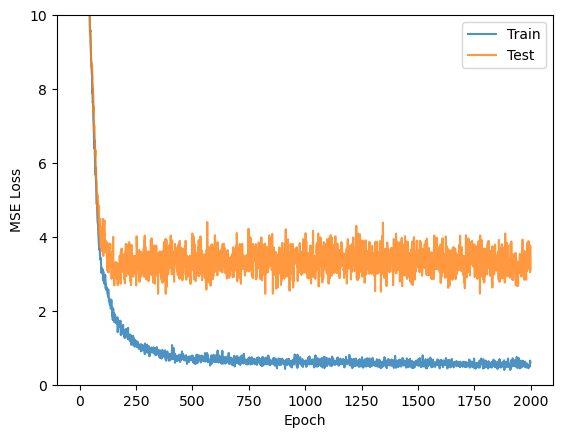

In [14]:
print('The best r2 value was:', best_R2)

fig, ax = plt.subplots()
ax.plot(train_loss_list, label='Train',alpha=0.8)
ax.plot(test_loss_list,label='Test',alpha=0.8)

ax.set_ylim(0,10)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()

plt.show()

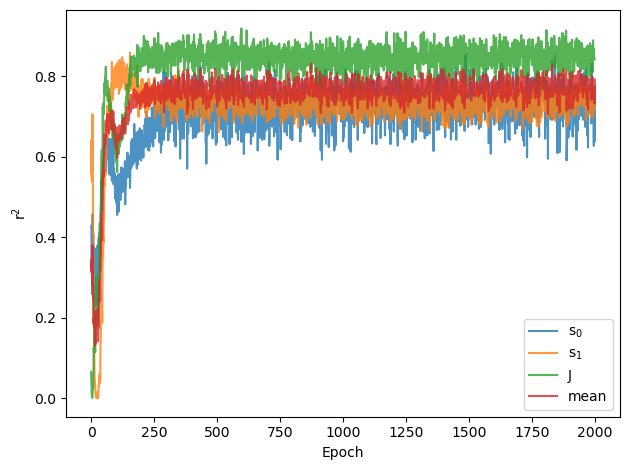

In [15]:
r2_array = np.array(r2_list)
labels = ['s$_0$', 's$_1$', 'J', 'mean']

fig, ax = plt.subplots()
for i in range(r2_array.shape[1]):
    ax.plot(r2_array[:,i],label=labels[i],alpha=0.8)

ax.set_xlabel('Epoch')
ax.set_ylabel('r$^2$')
ax.legend()
ax.tick_params(axis='both')
plt.tight_layout()
plt.show()

## Plot the predicted vs. actuals

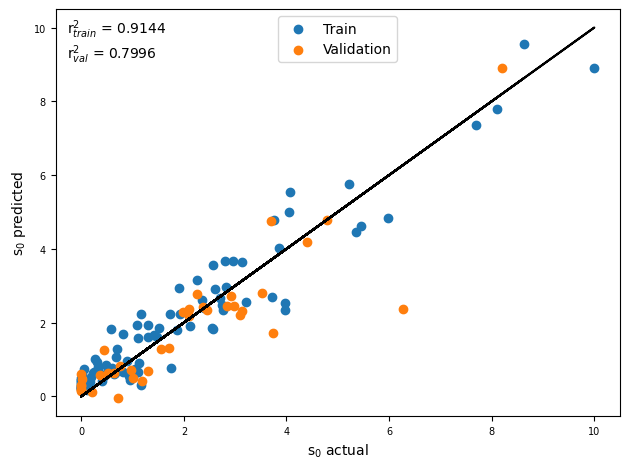

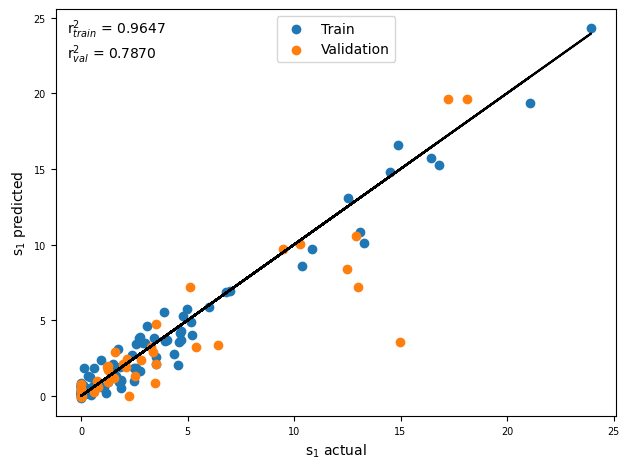

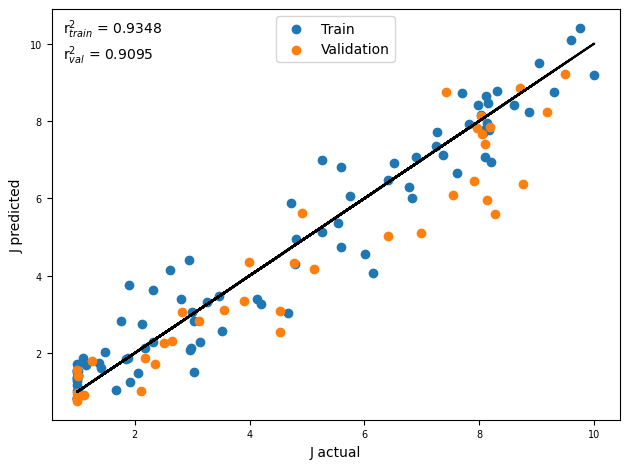

In [16]:
def plot_predictions(train_pred, train_actual, val_pred, val_actual, index, title):
    fig, ax = plt.subplots()
    
    r2_train = pearsonr(train_actual[:,index], train_pred[:,index])[0]**2
    r2_val = pearsonr(val_actual[:,index], val_pred[:,index])[0]**2
    
    ax.scatter(train_actual[:,index],train_pred[:,index],label='Train')
    ax.scatter(val_actual[:,index],val_pred[:,index],label='Validation')
    ax.plot(train_actual[:,index],train_actual[:,index],c='k')
    
    plt.text(0.02, 0.98, 'r$^2_{train}$ = %.4f\nr$^2_{val}$ = %.4f' % (r2_train,r2_val),
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

    ax.legend(loc='upper center')
        
    ax.set_xlabel('{} actual'.format(title))
    ax.set_ylabel('{} predicted'.format(title))
    ax.tick_params(axis='both')
    
    return ax

labels = ['s$_0$', 's$_1$', 'J',]

for i,label in enumerate(labels):
    ax = plot_predictions(best_train_predictions,best_train_actuals,
                     best_val_predictions, best_val_actuals,i,label)
    ax.tick_params(axis='both', labelsize=7)
    plt.tight_layout()